In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import requests
import os
from io import StringIO


import missingno as msno
import folium


from openai import OpenAI
from dotenv import load_dotenv
import re

from folium.plugins import MarkerCluster

pd.set_option('display.max_columns', None)

In [2]:
path = os.getcwd()
raw_data_path = path + "/../data/raw/"

## Get Weather Data

In [3]:
# The only way to get data from https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00023272/detail  was downloading
df_weather = pd.read_csv(path+"/../data/raw/weather.csv")

In [4]:
df_weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,WT03
0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2018-01-01,0.00,NaN,NaN,NaN,61.0,48.0,NaN,NaN
1,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2018-01-02,0.00,NaN,NaN,NaN,61.0,52.0,NaN,NaN
2,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2018-01-03,0.09,NaN,NaN,NaN,58.0,53.0,NaN,NaN
3,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2018-01-04,0.06,NaN,NaN,NaN,63.0,53.0,NaN,NaN
4,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2018-01-05,0.26,NaN,NaN,NaN,61.0,52.0,NaN,NaN


In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    2378 non-null   object 
 1   NAME       2378 non-null   object 
 2   LATITUDE   2378 non-null   float64
 3   LONGITUDE  2378 non-null   float64
 4   ELEVATION  2378 non-null   float64
 5   DATE       2378 non-null   object 
 6   PRCP       2378 non-null   float64
 7   SNOW       60 non-null     float64
 8   SNWD       869 non-null    float64
 9   TAVG       0 non-null      float64
 10  TMAX       2357 non-null   float64
 11  TMIN       2359 non-null   float64
 12  TOBS       30 non-null     float64
 13  WT03       1 non-null      float64
dtypes: float64(11), object(3)
memory usage: 260.2+ KB


In [6]:
print(df_weather.NAME.value_counts(), end='\n\n')
print(df_weather.STATION.value_counts(), end='\n\n')
print(df_weather.ELEVATION.value_counts(), end='\n\n')
print(df_weather[['LATITUDE', 'LONGITUDE']].value_counts())


NAME
SAN FRANCISCO DOWNTOWN, CA US    2378
Name: count, dtype: int64

STATION
USW00023272    2378
Name: count, dtype: int64

ELEVATION
45.7    2378
Name: count, dtype: int64

LATITUDE  LONGITUDE
37.7705   -122.4269    2378
Name: count, dtype: int64


## Our data is collected from single station for single location. All we need is `DATE`, `PRCP`, `TMAX` and `TMIN` columns.
### lets focus on those! 

In [7]:
df_weather = df_weather[['DATE', 'PRCP', 'TMIN', 'TMAX']]
df_weather.head()

,DATE,PRCP,TMIN,TMAX
0,2018-01-01,0.00,48.0,61.0
1,2018-01-02,0.00,52.0,61.0
2,2018-01-03,0.09,53.0,58.0
3,2018-01-04,0.06,53.0,63.0
4,2018-01-05,0.26,52.0,61.0


In [8]:
df_weather.isna().sum()

DATE     0
PRCP     0
TMIN    19
TMAX    21
dtype: int64

In [9]:
df_weather =df_weather.fillna(method='backfill')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    2378 non-null   object 
 1   PRCP    2378 non-null   float64
 2   TMIN    2378 non-null   float64
 3   TMAX    2378 non-null   float64
dtypes: float64(3), object(1)
memory usage: 74.4+ KB


### Lets fix the data type for column

In [10]:
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])

In [11]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2378 non-null   datetime64[ns]
 1   PRCP    2378 non-null   float64       
 2   TMIN    2378 non-null   float64       
 3   TMAX    2378 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 74.4 KB


In [12]:
df_weather.head()

,DATE,PRCP,TMIN,TMAX
0,2018-01-01,0.00,48.0,61.0
1,2018-01-02,0.00,52.0,61.0
2,2018-01-03,0.09,53.0,58.0
3,2018-01-04,0.06,53.0,63.0
4,2018-01-05,0.26,52.0,61.0


### Looks cool! Lets see on a plot if there is any outliers in our data

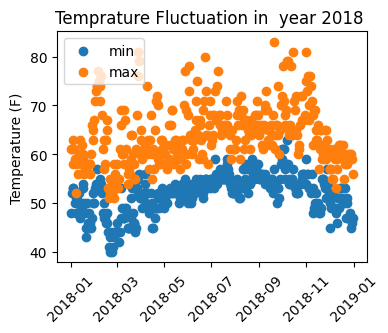

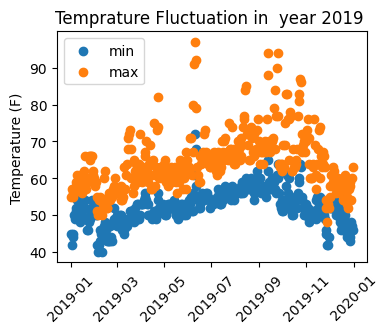

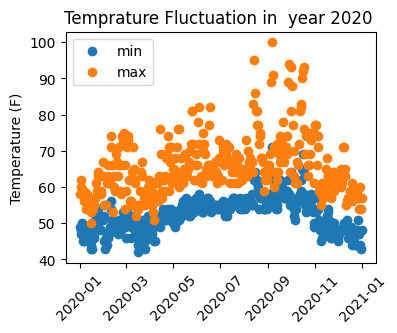

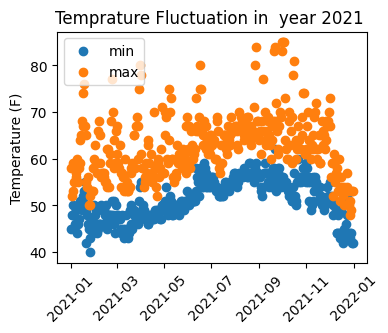

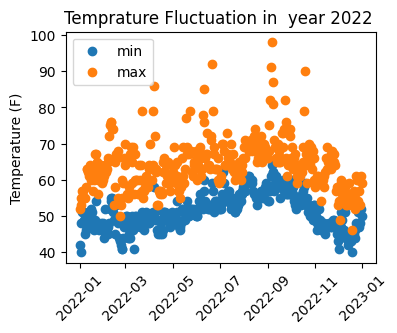

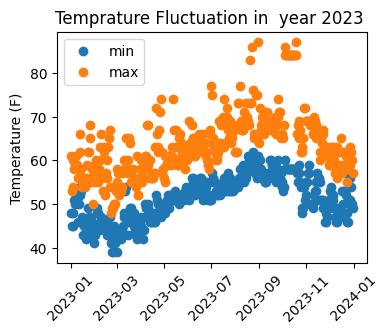

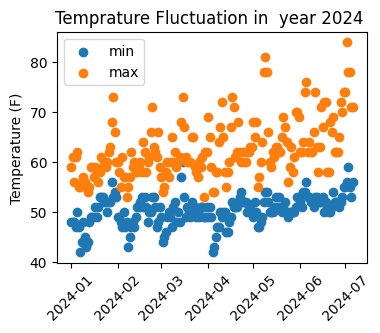

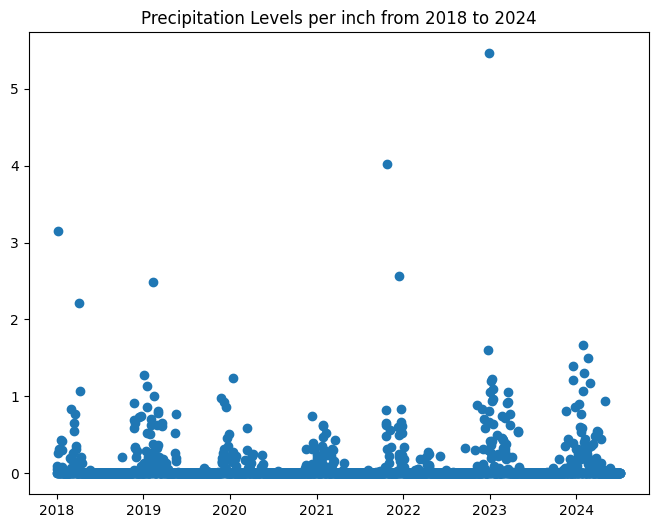

In [13]:

for a in range(7):
    plt.figure(figsize = (4, 3))
    plt.title(f'Temprature Fluctuation in  year {2018+a} ')
    plt.scatter(x=df_weather[df_weather['DATE'].dt.year==2018+a]['DATE'], y=df_weather[df_weather['DATE'].dt.year==2018+a]['TMIN'], label='min')
    plt.scatter(x=df_weather[df_weather['DATE'].dt.year==2018+a]['DATE'], y=df_weather[df_weather['DATE'].dt.year==2018+a]['TMAX'], label='max')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.ylabel("Temperature (F)")
    plt.show()

plt.figure(figsize=(8,6))
plt.title('Precipitation Levels per inch from 2018 to 2024')
plt.scatter(y=df_weather['PRCP'], x=df_weather['DATE'])
plt.show;

### Our temperature data looks fine. It follows a pattern and ranges between a minimum of 40 and a maximum of 100 degrees Fahrenheit.
## but we have couple outliers in Precipitation column. Lets figure that out!


In [14]:
df_weather[df_weather['PRCP']>2]

,DATE,PRCP,TMIN,TMAX
7,2018-01-08,3.15,51.0,58.0
94,2018-04-06,2.22,56.0,61.0
407,2019-02-13,2.49,47.0,60.0
1391,2021-10-24,4.02,56.0,62.0
1441,2021-12-13,2.57,44.0,60.0
1824,2022-12-31,5.46,50.0,59.0


### In this six years looks like only 6 times we had over 2 inces rain. That deserves to be confirmed. Since we have only 6 days I will google these days and I will hope to find some news about these crazy rainy days.

*   https://www.sfgate.com/weather/article/rainfall-totals-San-Francisco-Bay-Area-storm-12484213.php
*   https://www.mercurynews.com/2022/12/31/powerful-bay-area-storm-arrives-bringing-heavy-rains-and-wind-to-final-day-of-2022/
### These news are confirming that these outliers are actually true.

# Let's Store data to use in `sf_crime_prediction.ipynb` notebook

In [16]:
df_weather.to_csv(path + "/../data/processed/sf_weather_processed.csv", index=False)